# Investigations of PVDF-HFP (Polyvinylidene-Hexfluorpropylene)

In [1]:
import numpy as np
import scipy as spy
import scipy.integrate as integrate
import scipy.special as special
#from sympy import *
import matplotlib.pyplot as plt
#from py_functions import getalpha0

In [2]:
## Bending
# Define new constants
# https://www.m-petfilm.de/en/service/comparative-data-for-plastic-films/ for youngs mods

Ymt = 4.5e9 # youngs modulus in machined direction N/m
Ymm = 1e9 # yong mod in trans direction N/m 
nu = 0.33 # Poissons ratio
def BendingForce(lp,t,w,nu,Ymm,alp,lamb,A): 
    D = ((t**3)*w*Ymt)/(12*(1-nu)**2) # Bending stiffness
    k = (2*alp)/lp # Curvature of membrane

    Ub = D*k**2*lp # Bending Energy

    # Force w/ Bending
    Fwb = lamb*(np.cos(alp)/(1-np.cos(alp))) + 2*D*(alp-np.sin(alp)*np.cos(alp)/A) * (np.cos(alp)/(1-np.cos(alp))) * (1+(2*alp*np.tan(alp)**2)/(alp-np.tan(alp)))
    return Fwb, Ub

In [3]:
## Model Constants
resolution = 10000
Lpmax = 0.02 #[m]
step = Lpmax/resolution
Lp = np.arange(0,Lpmax,step) # [m] Initial Pouch Length - From original kellaris paper (2018)
perm0 = 8.85418782e-12#[m-3kg-1s4A2]
permr = 2.2 # for bopp.... 8.3 for PVDF-HFP
Eb = 700e6 #[V/m] the breakdown strength of BOPP
w = 0.12 #[m] from original kellaris paper
t = 18e-6 #[m] Bopp thickness used in initial designs
k = 135e6 #[Nm-1] Achilles tendon average sourced from Litchwark 2005
rho_f = 903 #[kgm-3] Bopp Density TEKRA (2020)
rho_o = 920 #[kgm-3] FR3 Dielectric oil Density Cargill (2018)
alpf = np.pi/2 #[rad] Assume circular cross section on stroke completion
Eper = 0.6 # Percentage of electrode coverage
Va = 10e3 # Actuation voltage
jj = 1 # Array Scaling

In [4]:
## Swept constants
#Va = np.linspace(0,10000,1000) # 0 -> 10kV res: 10V
E = Va/(2*t)
#Eper = np.linspace(0,1,0.01)

#Lambda for force
lamb = E**2*perm0*permr*w*t

# Electrode length
Le = Lp*Eper

#optimal fill eqn based on electrode coverage ratio
# !!! MIGHT NOT WORK WITH ARRAY !!!
alpeqn = ((1-Eper)**2)*(2/np.pi) # Easy to calc constant
y = 0.01 # intial guess of angle
it = 0.0001 # iteration
scale = 1.6/it # how many possible
end = int(scale) # int for loop
for i in range(0,end): # over scale
    
    func = (y-np.sin(y)*np.cos(y))/(y**2) - alpeqn # Find value of remaining equation with embedded alpha0
    
    if func >= 0: # root is transition from negative to positive in this case
        alp0 = y - it # previous value before sign flip returned       
        break #root found, stop
    else:
        y += it #move to next guess
        continue


#Height
h = Lp*(np.sin(alp0)/alp0) # Height [m]

#Area w/ restraints 
# !!! MIGHT NOT WORK WITH ARRAY !!!
A = (Lp - Le)**2 /np.pi # Area [m2]

#Blocking force
Fb = (lamb)*(np.cos(alp0)/(1-np.cos(alp0)))

Lpf = Lp - Le # Fully Deformed pouch length 

xmax = h - (Lpf*(np.sin(alpf)/alpf)) - Le # max displacement

alp = np.linspace(alp0,alpf,resolution) #sweep alpha

# intialise value matrices i = Lp variance, j = alp variance
lp = np.zeros((resolution,resolution))
le = np.zeros((resolution,resolution))
X = np.zeros((resolution,resolution))
P = np.zeros((resolution,resolution))
F = np.zeros((resolution,resolution))
Ub = np.zeros((resolution,resolution))
ku = np.zeros((resolution,resolution))
# Blocks of lp(alp) eqn sweep for each Lp
for i in range(len(A)):
    lpnum = 2*A[i]*np.square(alp)
    lpdom = (alp - np.sin(alp)*np.cos(alp))
    lp2 = lpnum/lpdom
    lp[i,:] = lp2**0.5
    lp[i,0] = Lp[i] # Removes unphysical discretisation error

    # electrode length sweep
    le[i,:] = Lp[i] - lp[i,:]

    # displacement sweep
    lpmp = np.sin(alp)/alp # lp multiplier in x
    lplpmp = lp[i,:]*lpmp
    X[i,:] = h[i] - lplpmp - le[i,:]

    # Load of spring
    P[i,:] = k*X[i,:]

    D = ((t**3)*w*Ymm)/(12*(1-nu**2)) # Bending stiffness
    ku[i,:] = (2*alp)/lp[i,:] # Curvature of membrane

    Ub[i,:] = D*ku[i,:]**2*lp[i,:] # Bending Energy

    # Force w/ Bending
    F[i,:] = jj*(lamb*(np.cos(alp)/(1-np.cos(alp))) + 2*D*((alp-np.sin(alp)*np.cos(alp))/A[i]) * (np.cos(alp)/(1-np.cos(alp))) * (1+(2*alp*np.tan(alp)**2)/(alp-np.tan(alp))))
    # Force output of actuator
    #F[i,:] = BendingForce(lp[i,:],t,w,nu,Ymm,alp,lamb,A[i])

C:\Users\mbgm4hm7\AppData\Local\Temp/ipykernel_13876/2859669240.py:75: RuntimeWarning: divide by zero encountered in true_divide
  ku[i,:] = (2*alp)/lp[i,:] # Curvature of membrane
C:\Users\mbgm4hm7\AppData\Local\Temp/ipykernel_13876/2859669240.py:77: RuntimeWarning: invalid value encountered in multiply
  Ub[i,:] = D*ku[i,:]**2*lp[i,:] # Bending Energy
C:\Users\mbgm4hm7\AppData\Local\Temp/ipykernel_13876/2859669240.py:80: RuntimeWarning: divide by zero encountered in true_divide
  F[i,:] = jj*(lamb*(np.cos(alp)/(1-np.cos(alp))) + 2*D*((alp-np.sin(alp)*np.cos(alp))/A[i]) * (np.cos(alp)/(1-np.cos(alp))) * (1+(2*alp*np.tan(alp)**2)/(alp-np.tan(alp))))


In [5]:
cut = np.zeros(resolution)
# Loop deletes anyhting after spring outforces actuator
for k in range(resolution):
    for i in range(resolution):
        if F[k,i] <= P[k,i]:
            cut[k] = i
            for j in range(i+1,resolution):
                F[k,j] = float("NaN")
                P[k,j] = float("NaN")
        else:
            continue

In [6]:
# Energies of actuator and SEE

x = np.zeros((resolution,resolution))
p = np.zeros((resolution,resolution))
f = np.zeros((resolution,resolution))
Usee = np.zeros(resolution)
Uact = np.zeros(resolution)

cut = cut.astype(int)
for i in range(resolution):
    
    end = cut[i]
    
    x = X[i,0:end] # Physically relevant values for integration 
    p = P[i,0:end]
    f = F[i,0:end]
    
    # Energy in spring
    Usee[i] = spy.integrate.trapezoid(p,x)
    
    # Energy output of actuator
    Uact[i] = spy.integrate.trapezoid(f,x)

In [7]:
# Actuator Masses 

mass = np.zeros(resolution)
for i in range(resolution):
    mass[i] = jj*(Lp[i]*t*w*2*rho_f + A[i]*w*rho_o) # film + oil mass

In [8]:
# Bounding box of actuator
xb = (jj+1) * np.sqrt(A/np.pi)
yb = w 
zb = h 
Vol = xb*yb*zb

In [9]:
# Specific Energies 

SUact = Uact/mass 
SUsee = Usee/mass

C:\Users\mbgm4hm7\AppData\Local\Temp/ipykernel_13876/2785228507.py:3: RuntimeWarning: invalid value encountered in true_divide
  SUact = Uact/mass
C:\Users\mbgm4hm7\AppData\Local\Temp/ipykernel_13876/2785228507.py:4: RuntimeWarning: invalid value encountered in true_divide
  SUsee = Usee/mass


In [10]:
Eff = Usee/Uact 

C:\Users\mbgm4hm7\AppData\Local\Temp/ipykernel_13876/413016973.py:1: RuntimeWarning: invalid value encountered in true_divide
  Eff = Usee/Uact


Text(0.5, 1.0, 'Specific Energy, (u) w/ Variable Pouch Length (Lp)')

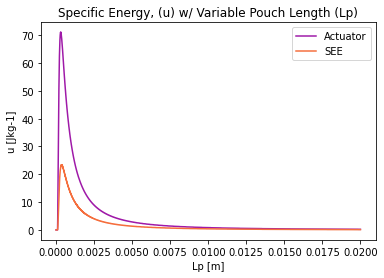

In [11]:
fig, ax = plt.subplots() 
# ax.plot(Lp,Usee)
ax.plot(Lp,SUact, color='#9F19A8', label="Actuator",)
ax.plot(Lp,SUsee, color='#F56E3D', label="SEE")
plt.xlabel('Lp [m]')
plt.ylabel('u [Jkg-1]')
plt.title('Specific Energy, (u) w/ Variable Pouch Length (Lp)')
leg = plt.legend(loc = 'upper right')

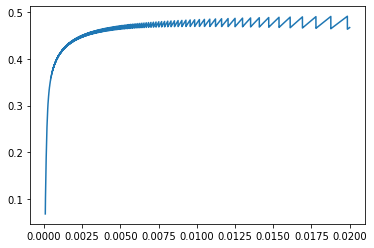

In [12]:
fig, ax = plt.subplots()
ax.plot(Lp,Eff)

In [13]:
index = np.argmax(SUact)
print(index)



0
